### Clonotype Diversity
:::{note}
Clonotype diversity is a rather complicated subject and different approaches work with different assumptions. In sc-AIRR analysis the term "population" can be defined in different ways depending on the scientific question (i.e. individuals, patient groups, clonotype cluster). Further, many different alpha diversity indices for many different applications have been developed and may come with different pitfalls {cite}`Finotello.2016`. We recommend to consult a combination of different indices as each index provides different information {cite}`Pelissier.2023`
:::

Scirpy provides ({func}`scirpy.tl.alpha_diversity`) to calculate alpha diversity and a corresponding visualization function ({func}`scirpy.pl.alpha_diversity`), which can utilize any diversity index implemented into the python package [`scikit-bio`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html#module-skbio.diversity.alpha) However, `scikit-bio` is not an initial requirement for `Scirpy` and needs to be installed and imported separately.

In [33]:
#!pip install scikit-bio

Alpha diversity indices are often applied in sc-AIRR studies to study differences between clonotype cluster distributions of distinct groups (e.g. treatment, disease, etc.). Calling {func}`scirpy.pl.alpha_diversity` with appropriate inputs to `groupby`, `metric` and `target_col` will result into an easily investigable bar plot. As an example, we can see below that `moderate` and `severe` patients might have a slightly reduced diversity (`D50`) compared to other groups.

<Axes: title={'center': 'Alpha diversity of clone_id_85_similarity by gex:Status_on_day_collection_summary'}, ylabel='D50'>

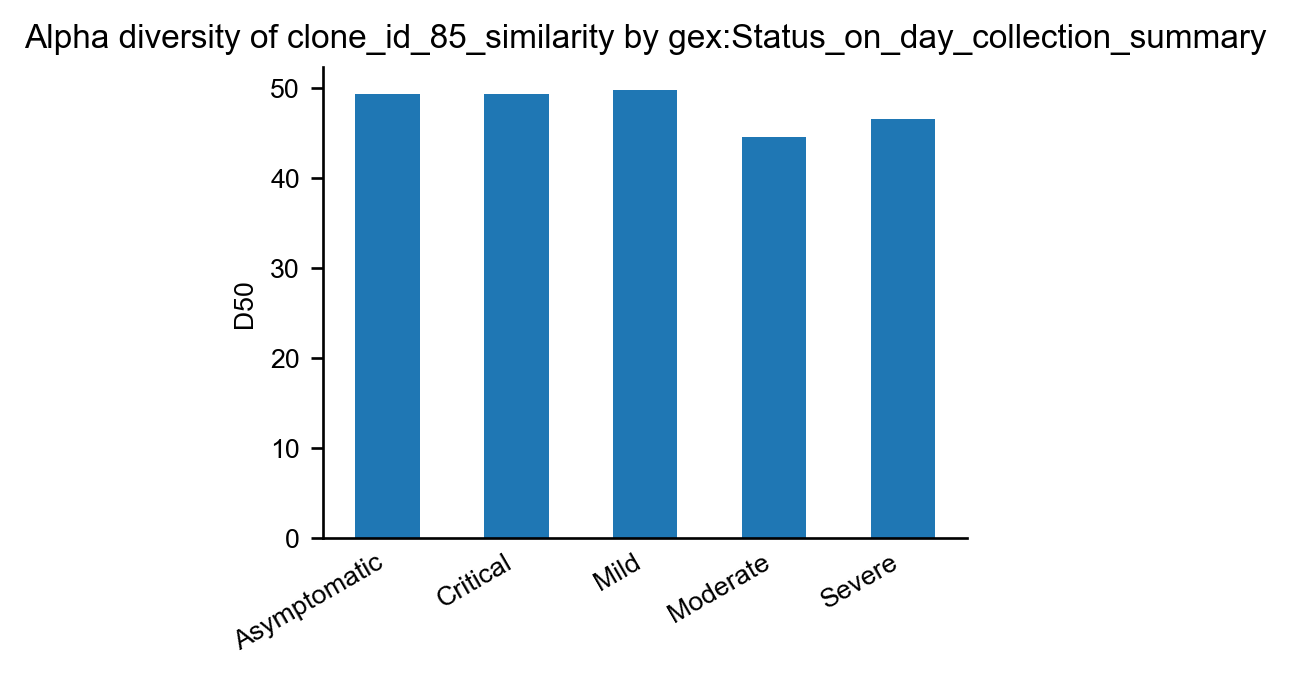

In [35]:
ir.pl.alpha_diversity(
    mdata,
    metric="D50",
    groupby="gex:Status_on_day_collection_summary",
    target_col="clone_id_85_similarity",
)

Rather than plotting/calculating many different indices individually, we can build a so-called diversity profile using Hill's unified diversity framework {cite}[Hill.1973]. This is done with calling `scirpy.tl.hill_diversity_profile`, which will finally return a dataframe, where each column represents a distinct group (defined by `groupby`) and rows are the range of calculated diversity orders based on the input to `target_col`. The range of diversity order *q* can be customized by setting `q_min`, `q_max` and `q_step`, respectively. 

In [37]:
diversity_profile_status = ir.tl.hill_diversity_profile(
    mdata,
    target_col="airr:clone_id_85_similarity",
    groupby="gex:Status_on_day_collection_summary",
    q_min=0,
    q_max=10,
    q_step=0.5,
)
diversity_profile_status.head(5)

gex:Status_on_day_collection_summary,Asymptomatic,Critical,Mild,Moderate,Severe
0.0,450.000000,935.000000,1147.000000,1039.000000,1203.000000
0.5,448.997653,929.315833,1145.957328,980.230645,1172.145639
1.0,447.757636,919.315499,1144.569348,852.834762,1116.833749
1.5,446.219087,900.943342,1142.693897,600.578125,1013.542627
2.0,444.307692,866.795958,1140.123711,317.852037,837.850505


The dataframe can be easily visualized using common python plotting packages like *Seaborn*. The more uneven the relative abundances per category, the more steeply its respective curve will decline. This is actually consistent with alpha diversity loss and thus its magnitude can be inferred by
inspecting the slope of each line {cite}`Chao.2014` 

Overall, the diversity profile below is consistent with the previous analysis and suggests that expansion took place preferential in all annotated celltypes except for immature and switched memory b cells. 

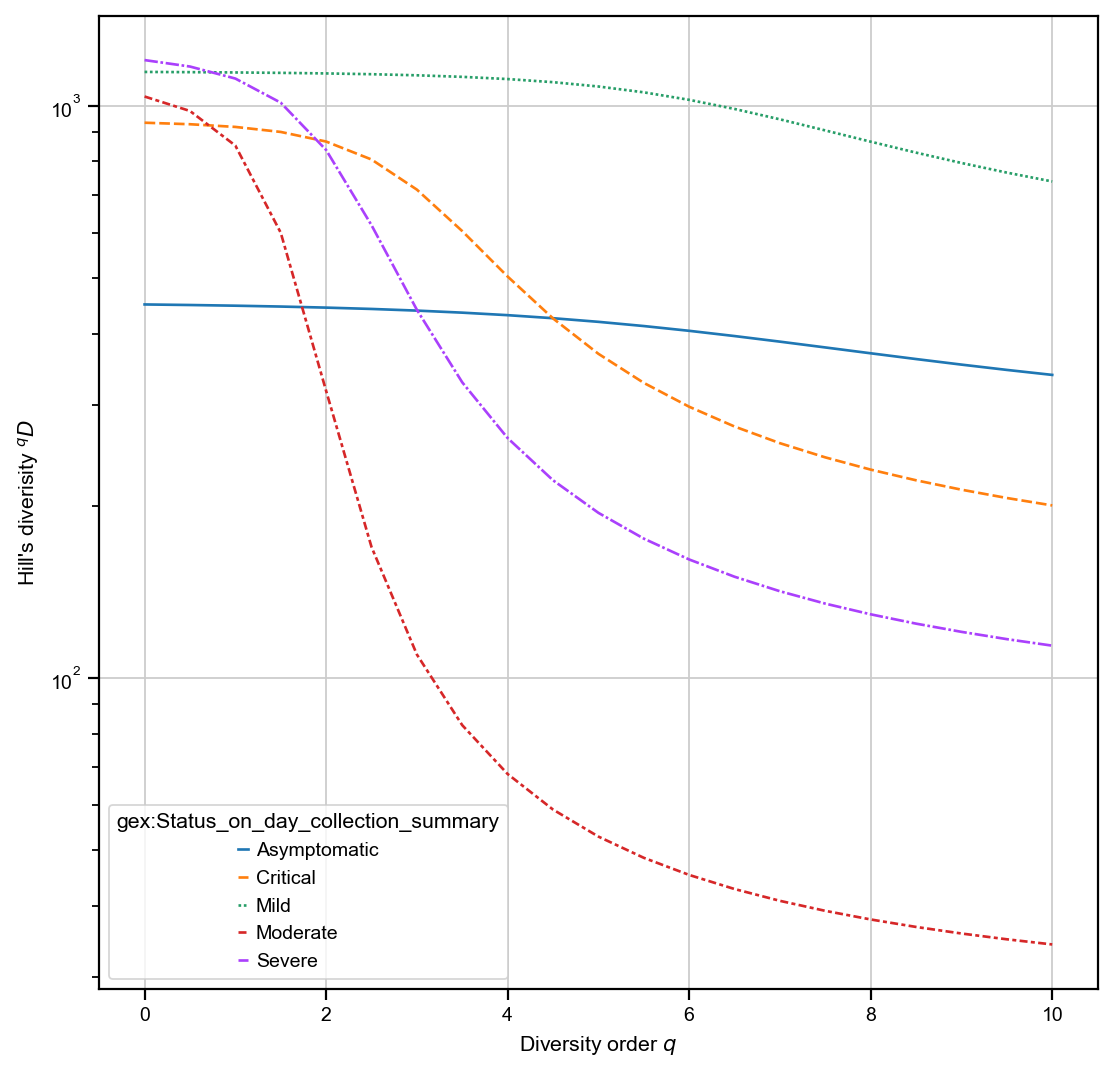

In [39]:
# manual customization of the resulting plot required
pl.figure(figsize=(8, 8))
sns.set_context("paper")
sns.lineplot(data=diversity_profile_status)
pl.xlabel("Diversity order $q$")
pl.ylabel("Hill's diverisity $^qD$")
pl.yscale("log")

Maybe the biggest advantage of using Hill numbers is that some diversity orders *q* are related to other common diversity indices like species richness ($^0D$), Shannon entropy (log($^1D$), Simpson index ($\frac{1}{^2D}$) and Berger-Parker dominance index ($\frac{1}{^{\infty}D}$).

Calling `scirpy.tl.convert_hill_table`, with the output of `scirpy.tl.hill_diversity_profile` and `convert_to = "diversity"` will automatically resolve those relations shown above and calculate each metric accordingly.

In [41]:
ir.tl.convert_hill_table(diversity_profile_status, convert_to="diversity")

gex:Status_on_day_collection_summary,Asymptomatic,Critical,Mild,Moderate,Severe
Observed richness,450.0,935.0,1147.0,1039.0,1203.0
Shannon entropy,6.104252,6.823629,7.042784,6.748566,7.018253
Inverse Simpson,444.307692,866.795958,1140.123711,317.852037,837.850505
Gini-Simpson,0.997749,0.998846,0.999123,0.996854,0.998806


If the research question at hand requires knowledge about (clonotype) evenness, this function can also be used to transform Hill numbers into evenness factor (`convert_to = "evenness_factor"`) and relative evenness (`convert_to = "relative_evenness"`) defined by {cite}`Jost.2010`

In [43]:
ir.tl.convert_hill_table(diversity_profile_status, convert_to="evenness_factor").head(5)
# ir.tl.convert_hill_table(diversity_profile_status, convert_to = "relative_evenness")

gex:Status_on_day_collection_summary,Asymptomatic,Critical,Mild,Moderate,Severe
0.0,1.000000,1.000000,1.000000,1.000000,1.000000
0.5,0.997773,0.993921,0.999091,0.943437,0.974352
1.0,0.995017,0.983225,0.997881,0.820823,0.928374
1.5,0.991598,0.963576,0.996246,0.578035,0.842513
2.0,0.987350,0.927055,0.994005,0.305921,0.696468
